# 0. Import Required Libraries

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
import sklearn
import matplotlib.pyplot as plt
import h5py
from lib.test import *

import mlflow

# 1. Define the CNN architecture

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=21, padding=10)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=15, padding=7)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=11, padding=5)
        
        self.batchnorm32 = nn.BatchNorm1d(num_features=32)
        self.batchnorm64 = nn.BatchNorm1d(num_features=64)
        self.batchnorm128 = nn.BatchNorm1d(num_features=128)
        self.batchnorm512 = nn.BatchNorm1d(num_features=512)
        
        self.fc1 = nn.Linear(4736, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 2)
        
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)     
        
        self.dropout2d = nn.Dropout2d(p=0.5)
        self.dropout = nn.Dropout(p=0.5)
    def forward(self, x):
        x = self.conv1(x.unsqueeze(1))
        x = F.relu(self.batchnorm32(x))
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = F.relu(self.batchnorm64(x))
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = F.relu(self.batchnorm128(x))
        x = self.maxpool(x)
        
        # Flatten input for fully connected layers
        x = x.view(x.shape[0], -1) 
        
        x = self.fc1(x)
        x = F.relu(self.batchnorm512(x))
        
        x = self.fc2(x)
        x = F.relu(self.batchnorm512(x))
        
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

# 2. Load the Data

In [3]:
import h5py

mixdata = h5py.File("../train/scsn_p_2000_2017_6sec_0.5r_pick_train_mix.hdf5", "r")
testdata = h5py.File("../test/scsn_p_2000_2017_6sec_0.5r_pick_test_mix.hdf5", "r")

In [4]:
def split_trainset(train_val_data, train_val_labels, ratio):
    train_ratio = ratio
    
    trainsize = int(len(train_val_data) * train_ratio)
    
    trainset = train_val_data[:trainsize]
    trainlabels = train_val_labels[:trainsize]
    
    valset = train_val_data[trainsize:]
    valabels = train_val_labels[trainsize:]
    
    return (trainset, trainlabels), (valset, valabels)

In [5]:
%%time

from torch.utils.data import DataLoader

batch_size = 500

train_size = 1 * 10 ** 5
train_ratio = 0.7
test_size = 1 * 10 ** 4

# Load test data
train_val_data = mixdata["X"][:train_size]
train_val_labels = mixdata["pwave"][:train_size]

(trainset, trainlabels), (valset, val_labels) = split_trainset(train_val_data, train_val_labels, train_ratio)

Wall time: 1.54 s


In [6]:
trainset = list(zip(trainset, trainlabels))

valset = list(zip(valset, val_labels))

In [7]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True)

In [8]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [9]:
model = CNN()

# 3. Add Multi-GPU Support to Model 
In order to run the model on multiple GPU's, we can use the nn.DataParallel layer. This layer requires that we move all tensors to the cuda:0 (the default gpu) before we can pass them through the network. 

In [10]:
def parallelize(model):
    device_ids = [i for i in range(torch.cuda.device_count())]
    model = torch.nn.DataParallel(model, device_ids=device_ids)
    return model

In [11]:
model = parallelize(model)
model

DataParallel(
  (module): CNN(
    (conv1): Conv1d(1, 32, kernel_size=(21,), stride=(1,), padding=(10,))
    (conv2): Conv1d(32, 64, kernel_size=(15,), stride=(1,), padding=(7,))
    (conv3): Conv1d(64, 128, kernel_size=(11,), stride=(1,), padding=(5,))
    (batchnorm32): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm64): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm128): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm512): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=4736, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=2, bias=True)
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout2d): Dropout2d(p=0.5)
    (dropout): Dropout(p=0.5)
 

# 4. Define Loss Function and Optimizer
Here we define the loss function and optimizer. For the loss function (criterion), we use the binary cross entropy with logits loss (BCEWithLogitsLoss). This function applies a sigmoid as well as calculates the cross entropy. 

In [12]:
from torch import optim

lr = 0.001

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# 5. Training and Validation

## TODO -- Save model on validation improvement. Then load model when testing and evaluating. 

In [13]:
mlflow.set_tracking_uri("file:.\mlruns")
mlflow.start_run()

<ActiveRun: info=<RunInfo: run_uuid='14280e0426984156a7696b4567494c32', experiment_id=0, name='', source_type=4, source_name='C:\\Users\\rober\\Miniconda3\\envs\\eew\\lib\\site-packages\\ipykernel_launcher.py', entry_point_name=None, user_id='unknown', status=1, start_time=1551928330272, end_time=None, source_version=None, lifecycle_stage='active', artifact_uri='.\\mlruns\\0\\14280e0426984156a7696b4567494c32\\artifacts'>, data=None>

In [14]:
%%time

epochs = 10

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    for batch, labels in trainloader:
        # ============================================
        #            TRAINING
        # ============================================
        batch, labels = batch.to(device), labels.to(device)
        # Clear gradients in optimizer
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(batch)
        # Calculate loss
        loss = criterion(output, labels.type(torch.cuda.LongTensor).view(labels.shape, 1))
        train_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()
    else:
        with torch.no_grad():
            model.eval()
            val_loss = 0

            for batch, labels in val_loader:
                # ============================================
                #            VALIDATION
                # ============================================
                batch, labels = batch.to(device), labels.to(device)
                # Forward pass
                ouput = model.forward(batch)
                # Calculate loss
                loss = criterion(output, labels.type(torch.cuda.LongTensor).view(labels.shape, 1))
                val_loss += loss.item()
                
    # Print epoch summary
    t_loss_avg = train_loss / len(trainloader)
    v_loss_avg = val_loss / len(val_loader)
    
    mlflow.log_metric("train_loss", t_loss_avg)
    mlflow.log_metric("val_loss", v_loss_avg)
    
    train_losses.append(t_loss_avg)
    val_losses.append(v_loss_avg)
    
    print('Epoch [{:5d}/{:5d}] | train loss: {:6.4f} | validation loss: {:6.4f}'.format(
            epoch+1, epochs, t_loss_avg, v_loss_avg))

Epoch [    1/   10] | train loss: 0.0624 | validation loss: 3.0796
Epoch [    2/   10] | train loss: 0.0416 | validation loss: 3.2674
Epoch [    3/   10] | train loss: 0.0355 | validation loss: 3.4383
Epoch [    4/   10] | train loss: 0.0293 | validation loss: 3.5375
Epoch [    5/   10] | train loss: 0.0235 | validation loss: 4.0531
Epoch [    6/   10] | train loss: 0.0196 | validation loss: 4.1795
Epoch [    7/   10] | train loss: 0.0143 | validation loss: 4.6855
Epoch [    8/   10] | train loss: 0.0102 | validation loss: 5.1724
Epoch [    9/   10] | train loss: 0.0082 | validation loss: 5.5341
Epoch [   10/   10] | train loss: 0.0056 | validation loss: 6.0370
Wall time: 3min 59s


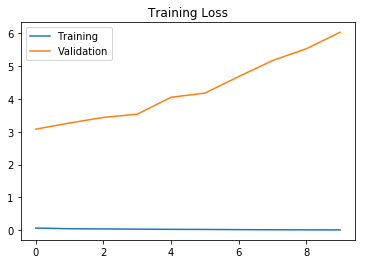

In [15]:
# add learning curve plot
train_loss = np.array(train_loss)

plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.title("Training Loss")
plt.legend()

# 6. Testing Model Performance

For testing model performance, we'll be using scikit learn's metrics library. Scikit learn provides a handful of builtin classfication metrics which we can take advantage of. In order to use them with pytorch, we'll have to move the tensors from GPU to CPU and convert them to numpy arrays. 

1. Classification Report  
    a. Precision  
    b. Recall  
    c. F1 Score
2. Accuracy
3. AUC-ROC

In [16]:
%%time

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

test_path = "../test/scsn_p_2000_2017_6sec_0.5r_pick_test_mix.hdf5"

y_true, y_pred, y_probs = test_model(model, test_path, test_size, device="cuda")

report = classification_report(y_true, y_pred, target_names=["pwave", "noise"])
report_dict = classification_report(y_true, y_pred, target_names=["pwave", "noise"], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)
roc_auc_score = roc_auc_score(y_true, y_probs)

print(report)
print("Accuracy: {:.4}%".format(accuracy * 100))
print("ROC Score: ", roc_auc_score)

              precision    recall  f1-score   support

       pwave       1.00      0.83      0.91      5000
       noise       0.85      1.00      0.92      5000

   micro avg       0.91      0.91      0.91     10000
   macro avg       0.93      0.91      0.91     10000
weighted avg       0.93      0.91      0.91     10000

Accuracy: 91.4%
ROC Score:  0.9843968200000001
Wall time: 3.81 s


In [17]:
mlflow.log_param("epochs", epochs)
mlflow.log_param("learning_rate", lr)
mlflow.log_param("device", device)

mlflow.log_metric("accuracy", accuracy)
mlflow.log_metric("auc_roc_score", roc_auc_score)

for category in report_dict:
    for metric, value in report_dict[category].items():
        metric_name = category + "_" + metric
        mlflow.log_metric(metric_name, value)
        
mlflow.end_run()

# References

1. https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2017JB015251
2. http://scedc.caltech.edu/research-tools/deeplearning.html#picking_polarity